# Modelling and Evaluation Notebook
## Selecting, validating, and evaluating different models on the data

In [1]:
%load_ext watermark

In [2]:
%watermark -a 'Daniel Soutar' -d -nrmv --packages numpy,pandas,sklearn,matplotlib,seaborn,imblearn

Daniel Soutar 2018-03-21 

CPython 3.6.3
IPython 6.2.1

numpy 1.14.1
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.2.0
seaborn 0.8.1
imblearn 0.3.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git repo   : https://github.com/danielsoutar/CS4098.git


In [58]:
import Loader
import glob
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, make_scorer, roc_auc_score
from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits, make_friedman1
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn import svm
from scipy import interp
import itertools
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import scikitplot as skplt

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    my_sum = sum(arr)
    arr = arr / my_sum
#     print(file[9:] + ": " + str(sum(arr)))
    X[i] = arr


(1797,)


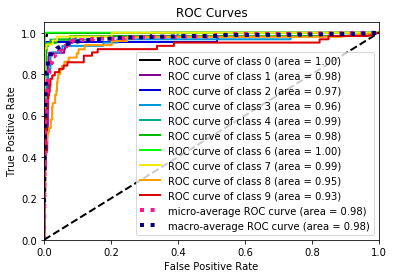

In [51]:
# The usual train-test split mumbo-jumbo

X, y = load_digits(return_X_y=True)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

# The magic happens here
skplt.metrics.plot_roc_curve(y_test, predicted_probas)
plt.show()

In [52]:
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_smote, y_smote = sampler.fit_sample(X, y)

smote_X_minority = np.take(X_smote, np.where(y_smote == 1), axis=0)[0]
smote_y_minority = np.take(y_smote, np.where(y_smote == 1), axis=0)[0]

smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(X_smote, y_smote, train_size=0.8, test_size=0.2, random_state=0, stratify=y_smote)

class_names = ['non-fatal', 'fatal']

In [53]:
plt.rc('legend',fontsize=6)

def plot_roc_multiple(X, y, classifiers, name):
    print(classifiers)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for classifier in classifiers:
        clf = classifier
        clf.fit(X_train, y_train)
        predicted_probas = clf.predict_proba(X_test)

        # The magic happens here
        skplt.metrics.plot_roc_curve(y_test, predicted_probas, curves=('macro'))
        plt.show()
#         print(classifier)
#         cv = StratifiedKFold(n_splits=5)

#         tprs = []
#         aucs = []
#         mean_fpr = np.linspace(0, 1, 100)

#         i = 0
#         for train, test in cv.split(X, y):
#             predicted_probas = classifier.fit(X[train], y[train]).predict_proba(X[test])
#             fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#             tprs.append(interp(mean_fpr, fpr, tpr))
#             tprs[-1][0] = 0.0
#             roc_auc = auc(fpr, tpr)
#             aucs.append(roc_auc)
#             plt.plot(fpr, tpr, lw=1, alpha=0.6,
#                      label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#             i += 1

#         mean_tpr = np.mean(tprs, axis=0)
#         mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_auc = np.std(aucs)
#         plt.plot(mean_fpr, mean_tpr, color='b',
#                  label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#                  lw=2, alpha=.8)

#         std_tpr = np.std(tprs, axis=0)
#         tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#         tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#         plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                          label=r'$\pm$ 1 std. dev.')

#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#                  label='Luck', alpha=.8)
  
#     plt.xlim([-0.03, 1.03])
#     plt.ylim([-0.03, 1.03])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve: ' + name)
#     plt.legend(loc="lower right")
#     plt.show()

Let's do Naive Bayes first.
Naive Bayes implements Bayes' Theorem with the caveat that we make a 'naive' assumption of independence. That is, we assume every feature is independent of the others. With the GaussianNB classifier we further assume that the data follows a Gaussian or normal distribution. 

The nice thing about this classifier is that even when it is patently nonsense to assume independence of the features, in practice this often still works well, with uses including spam filtering. Additionally, it is very computationally cheap to train, straightforward to understand, and requires very little tuning apart from setting the 'priors', or the prior class distributions.

After SMOTE we have 34 positives, but let's not hardcode the values of our class priors - let the ratios in the data do the work for us!

In [54]:
smote_positives_ratio = smote_X_minority.shape[0]/X_smote.shape[0]
smote_negatives_ratio = 1 - smote_positives_ratio

smote_nb_priors = np.array([smote_positives_ratio, smote_negatives_ratio])
naive_bayes_inc_smote_priors = GaussianNB(smote_nb_priors)

plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_inc_smote_priors], "Naïve Bayes")

smote_y_pred = cross_val_predict(naive_bayes_inc_smote_priors, smote_X_train, smote_y_train, cv=StratifiedKFold(n_splits=10))
cnf_matrix = confusion_matrix(smote_y_train, smote_y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix: Naive Bayes', normalize=False)

[GaussianNB(priors=array([0.10027, 0.89973]))]


ValueError: Number of priors must match number of classes.

In [ ]:
X_minority = np.take(X, positives, axis=0)

original_positives_ratio = X_minority.shape[0]/X.shape[0]
original_negatives_ratio = 1 - original_positives_ratio

original_nb_priors = np.array([original_positives_ratio, original_negatives_ratio])

naive_bayes_wo_priors = GaussianNB(original_nb_priors)

plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_wo_priors], "Naïve Bayes")

smote_y_pred = cross_val_predict(naive_bayes_wo_priors, smote_X_train, smote_y_train, cv=StratifiedKFold(n_splits=10))
cnf_matrix = confusion_matrix(smote_y_train, smote_y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix: Naive Bayes', normalize=False)

The Support Vector Machine (SVM) is another classifier which works by creating a hyperplane that has the largest margin in separating the data. Intuitively, if there is a line with a really big margin, then that implies the model has found a good strategy for classification. We use the various points in the feature space that correspond to our examples as vectors to calculate the margin for the hyperplane, hence the term 'support vectors' because they 'prop up' the hyperplane.

The SVM does have considerably greater scope for tuning than a Naive Bayes classifier, but it is more powerful (due to its being a universal approximator) and makes fewer prior assumptions about the data. Let's see what it can do.

In [ ]:
cross_validation = StratifiedKFold(random_state=0, n_splits=10)

svm_parameter_grid = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000], 'gamma':[0.001, 0.01, 0.1, 1]}

balanced_svm = svm.SVC(random_state=0, probability=True, class_weight='balanced')

grid_search = GridSearchCV(balanced_svm, param_grid=svm_parameter_grid, cv=cross_validation, 
                           scoring=make_scorer(f1_score, average='micro'))

grid_search.fit(smote_X_train, smote_y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

balanced_svm = grid_search.best_estimator_
print(balanced_svm)
print(balanced_svm.support_vectors_)

In [ ]:
print(balanced_svm.support_vectors_.shape)

In [ ]:
plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_wo_priors, balanced_svm], "Naïve Bayes v Support Vector Machine")

Onto decision trees. These classifiers attempt to 'divide and conquer' the data by partitioning it based on the results of a series of binary rules. Those rules that maximise the information gain from dividing the data are made explicit, making the decision tree a white-box model and thus extremely useful in a medical context. They are however prone to overfitting if we aren't careful with the maximum depth. So we will need to pay close attention to that particular parameter.

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(random_state=0)

parameter_grid = { # 'criterion': ['gini', 'entropy'],
                  # 'splitter': ['best', 'random'],
                  'max_depth': [x+1 for x in range(10)],
                  'max_features': [x+1 for x in range(21)]}

cross_validation = StratifiedKFold(random_state=0, n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(smote_X_train, smote_y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_visualization = []

for grid_pair in grid_search.cv_results_:
    if "mean_test_score" == grid_pair:
        for score in grid_search.cv_results_[grid_pair]:
            grid_visualization.append(score)
    
grid_visualization = np.array(grid_visualization)

grid_visualization.shape = (10, 21)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(21) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(10) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

In [ ]:
nb_priors = np.array([0.39, 0.61])
svm_params = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000]}

class_names = ['non-fatal', 'fatal']

my_svm = svm.SVC(random_state=0)

classifiers = [GridSearchCV(my_svm, svm_params, refit=True), 
                GaussianNB(nb_priors),
                DecisionTreeClassifier(random_state=0),
                DecisionTreeClassifier(random_state=0, max_depth=3, class_weight='balanced')]
names = ["SVM", "NB", "DT-basic", "DT-adjusted"]

for clf, name in zip(classifiers, names):
    y_pred = cross_val_predict(clf, smote_X_train, smote_y_train, cv=10)
    scores = cross_val_score(clf, smote_X_train, smote_y_train, cv=10, scoring='f1')
    
    if name is "SVM":
        clf.fit(smote_X_train, smote_y_train)
        print(clf.best_estimator_)

    print("F1-score for %s: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))

    cnf_matrix = confusion_matrix(smote_y_train, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalised Confusion Matrix: ' + name, normalize=False)

In [ ]:

my_tree = classifiers[-1]

my_tree.fit(X_res, y_res)

dot_data = export_graphviz(my_tree, out_file=None) 
graph = graphviz.Source(dot_data)

dot_data = export_graphviz(my_tree, out_file=None,
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph
# graph.render("cancer") 

In [56]:

# X = get X
# y = get y

scaler      = FunctionTransformer(norm)
est         = DecisionTreeClassifier(random_state=0)
selector    = feature_selection.RFE(classifier)
my_pipeline = pipeline.Pipeline([('scaler', scaler), ('selector', selector), ('est', est)])

selector = feature_selection.RFE(my_pipeline)
clf = GridSearchCV


# def norm(arr):
#   my_sum = sum(arr)
#   normed_arr = arr / my_sum
#   return normed_arr

# For a given classifier with particular parameter settings:
#   For fold in k folds of cross validation (potentially stratified):
#     let X_fold, y_fold = X, y of the fold of the dataset - which is potentially SMOTEd at the beginning
#     Scale X_fold using our norm function
#     From the scaled data, pick the most informative features using RFE
#     Train the classifier on the preprocessed data
#     Predict, get results for both class-prediction and raw probabilities (former for confusion matrix, 
#                                                                           latter for ROC/PR curves)
# ...
# Evaluate using the acquired class predictions and probabilities - e.g. ROC/PR curves, 
# confusion matrices, probably plot training and validation error rates with plain accuracy metric to 
# detect overfitting or underfitting.

NameError: name 'classifier' is not defined

In [ ]:
# X, y = cleaned data

# Convert X, y to appropriate data types (e.g. binary labels)

# For a given model with particular parameter settings (potentially from GridSearchCV?):
#   For fold in k folds of cross validation (potentially stratified):
#     let X_fold, y_fold = X, y of the fold of X_train, y_train
#     prepared_features = From remaining folds, pick the most informative features using RFE
#     Train the model on remaining folds using prepared_features
#     Predict for X_fold, y_fold, get results for either class-prediction/raw probabilities or regression
# ...


In [57]:
m = 115
upper = 201
step = 20
    
X, y, positives = Loader.load_new_dataset_extending_ranges(m=m, upper=upper, step=step, \
                                                    display_plot=False, pretty_print=False)

features = ["1-" + str(x) for x in range(step, upper, step)]

X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                 np.take(y, positives, axis=0), np.delete(y, positives, axis=0)

In [ ]:
m = 115
upper = 31
step  = 5

X, y, positives = Loader.load_new_dataset_separate_ranges(m=115, upper=upper, step=step, display_plot=False)

features = [str(x-step+1) + "-" + str(x) for x in range(step, upper, step)]

X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                 np.take(y, positives, axis=0), np.delete(y, positives, axis=0)

./LargerDataset/2016_12_17__0690.czi_3064_job2861.object_results.p
Number of clusters: 5789.0
[1515. 1072.  598.  447. 2157.]


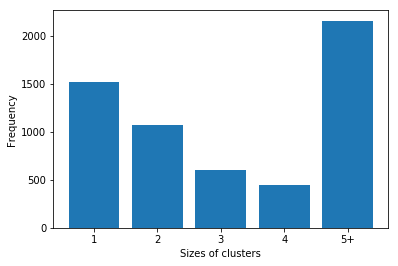


./LargerDataset/2016_12_17__0691(ext).czi_3066_job2958.object_results.p
Number of clusters: 1013.0
[343. 177.  94.  60. 339.]


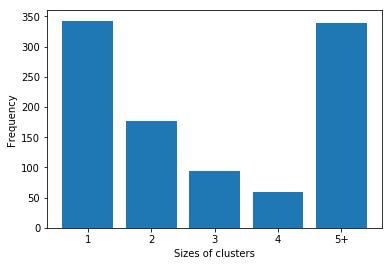


./LargerDataset/2016_12_17__0692(ext).czi_3068_job2863.object_results.p
Number of clusters: 1414.0
[377. 229. 147.  72. 589.]


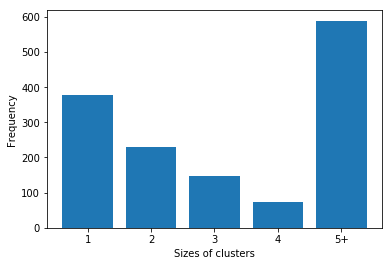


./LargerDataset/2016_12_17__0693(ext).czi_3070_job2864.object_results.p
Number of clusters: 2563.0
[ 589.  391.  224.  160. 1199.]


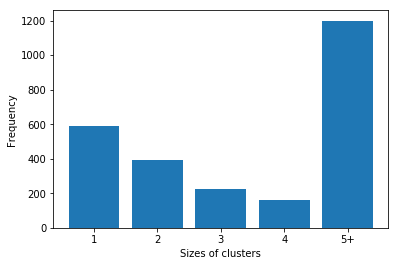


./LargerDataset/2016_12_17__0694(ext).czi_3072_job2865.object_results.p
Number of clusters: 3843.0
[1510.  677.  377.  224. 1055.]


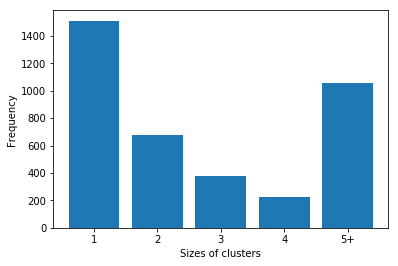


./LargerDataset/2016_12_17__0695(ext).czi_3073_job2866.object_results.p
Number of clusters: 1966.0
[495. 369. 234. 163. 705.]


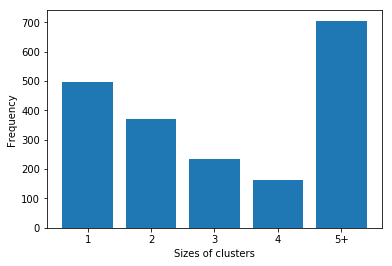


./LargerDataset/2016_12_17__0696(ext).czi_3075_job2878.object_results.p
Number of clusters: 2950.0
[ 752.  429.  257.  188. 1324.]


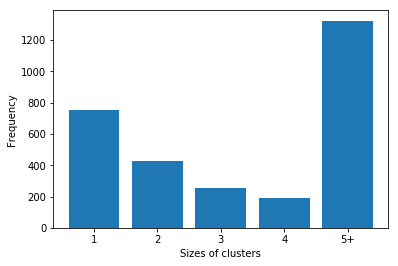


./LargerDataset/2016_12_17__0697(ext).czi_3076_job2867.object_results.p
Number of clusters: 848.0
[283. 177.  85.  48. 255.]


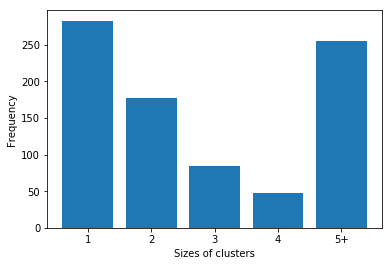


./LargerDataset/2016_12_17__0698(ext).czi_3077_job2868.object_results.p
Number of clusters: 697.0
[234. 117.  68.  56. 222.]


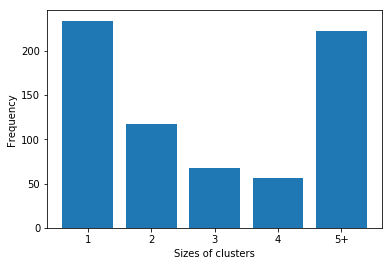


./LargerDataset/2016_12_17__0699(ext).czi_3078_job2869.object_results.p
Number of clusters: 617.0
[194.  95.  52.  34. 242.]


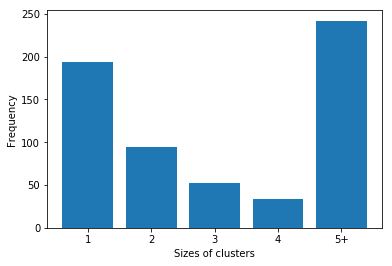


./LargerDataset/2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p
Number of clusters: 4284.0
[ 898.  594.  408.  322. 2062.]


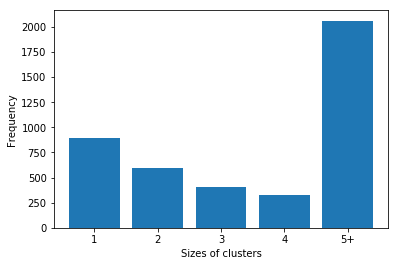


./LargerDataset/2016_12_17__0701(ext).czi_3080_job2871.object_results.p
Number of clusters: 1897.0
[444. 244. 152.  95. 962.]


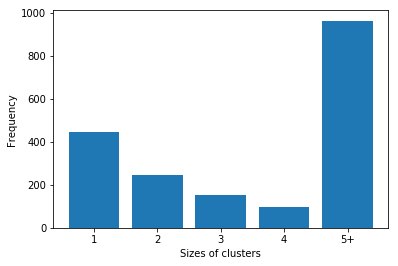


./LargerDataset/2016_12_17__0702(ext).czi_3081_job2872.object_results.p
Number of clusters: 2384.0
[756. 391. 194. 132. 911.]


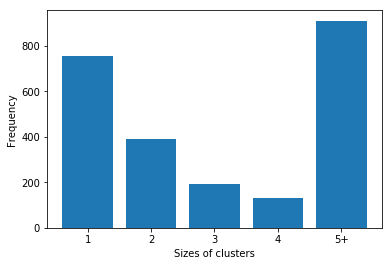


./LargerDataset/2016_12_17__0703(ext).czi_3082_job2873.object_results.p
Number of clusters: 2642.0
[811. 440. 279. 179. 933.]


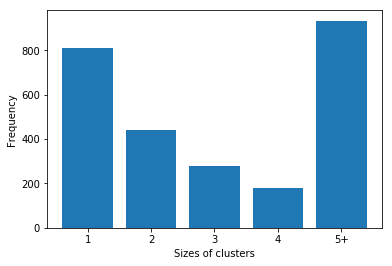


./LargerDataset/2016_12_17__0704(ext).czi_3083_job2875.object_results.p
Number of clusters: 3294.0
[ 647.  437.  269.  182. 1759.]


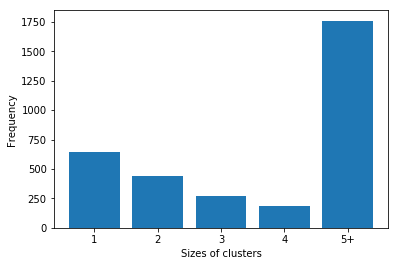


./LargerDataset/2016_12_17__0706(ext).czi_3085_job2876.object_results.p
Number of clusters: 3013.0
[1368.  489.  244.  136.  776.]


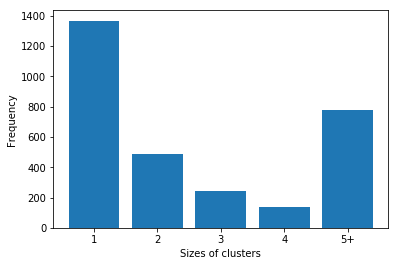


./LargerDataset/2016_12_17__0707.czi_3027_job2857.object_results.p
Number of clusters: 1480.0
[298. 168. 114.  76. 824.]


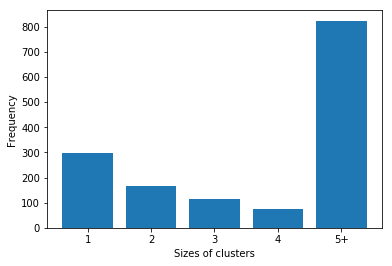


./LargerDataset/2016_12_17__0708(ext).czi_3086_job2879.object_results.p
Number of clusters: 2893.0
[ 683.  435.  308.  195. 1272.]


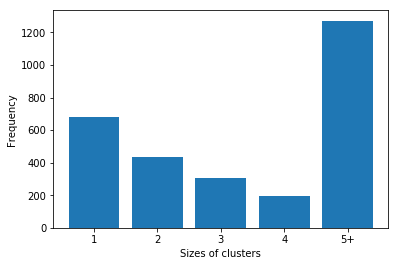


./LargerDataset/2016_12_17__0709(ext).czi_3087_job2880.object_results.p
Number of clusters: 2414.0
[ 604.  338.  240.  177. 1055.]


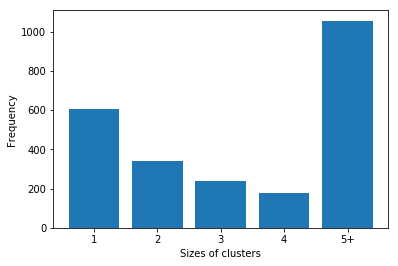


./LargerDataset/2016_12_17__0710(ext).czi_3088_job2881.object_results.p
Number of clusters: 1293.0
[378. 203. 106.  91. 515.]


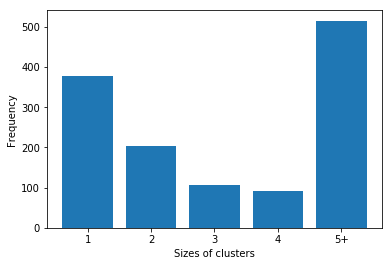


./LargerDataset/2016_12_17__0711(ext).czi_3089_job2882.object_results.p
Number of clusters: 2194.0
[564. 378. 230. 133. 889.]


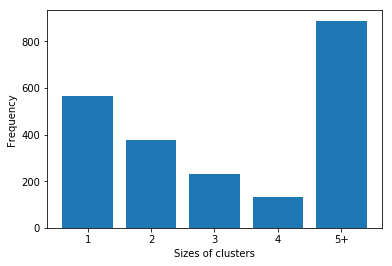


./LargerDataset/2016_12_17__0712(ext).czi_3090_job2883.object_results.p
Number of clusters: 2108.0
[ 509.  250.  166.  101. 1082.]


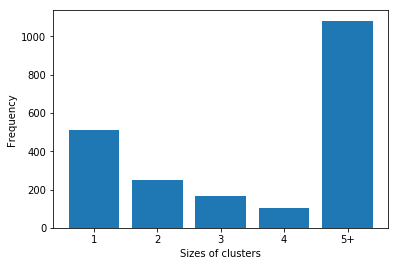


./LargerDataset/2016_12_17__0713(ext).czi_3091_job2884.object_results.p
Number of clusters: 776.0
[216.  67.  47.  20. 426.]


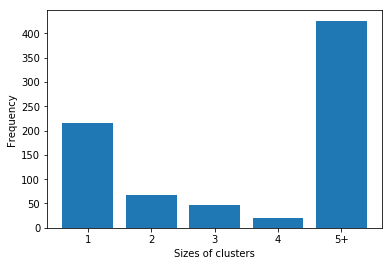


./LargerDataset/2016_12_17__0714(ext).czi_3092_job2885.object_results.p
Number of clusters: 590.0
[167.  93.  49.  37. 244.]


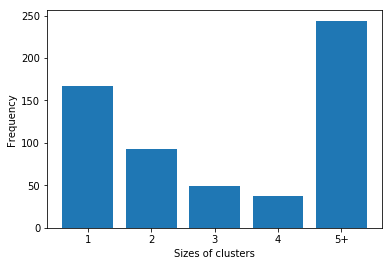


./LargerDataset/2016_12_17__0715(ext).czi_3093_job2886.object_results.p
Number of clusters: 2235.0
[545. 379. 232. 175. 904.]


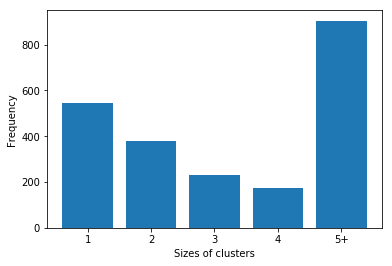


./LargerDataset/2016_12_17__0716(Ext).czi_3094_job2887.object_results.p
Number of clusters: 1881.0
[361. 243. 171. 124. 982.]


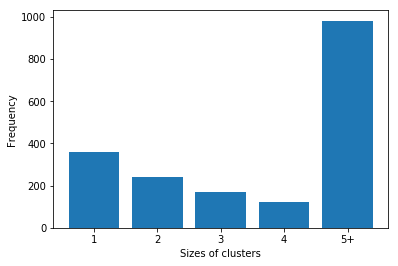


./LargerDataset/2016_12_17__0717(ext).czi_3095_job2888.object_results.p
Number of clusters: 1504.0
[380. 235. 114.  90. 685.]


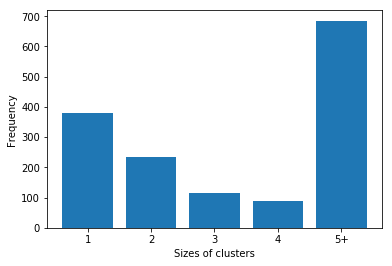


./LargerDataset/2016_12_17__0719(ext).czi_3096_job2889.object_results.p
Number of clusters: 1015.0
[443. 142.  52.  45. 333.]


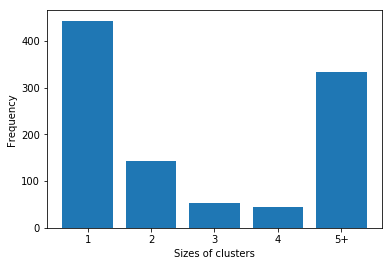


./LargerDataset/2016_12_17__0720(ext).czi_3097_job2890.object_results.p
Number of clusters: 4845.0
[1432.  855.  536.  333. 1689.]


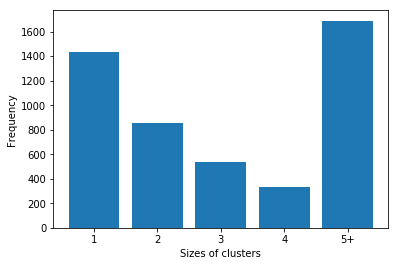


./LargerDataset/2016_12_17__0721(ext).czi_3098_job2891.object_results.p
Number of clusters: 1546.0
[600. 257. 128.  86. 475.]


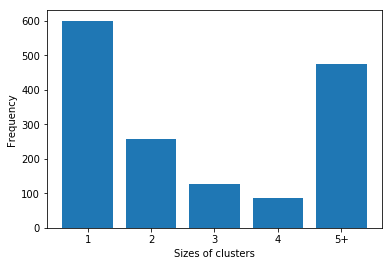


./LargerDataset/2016_12_17__0722(Ext).czi_3099_job2892.object_results.p
Number of clusters: 773.0
[234. 160.  76.  41. 262.]


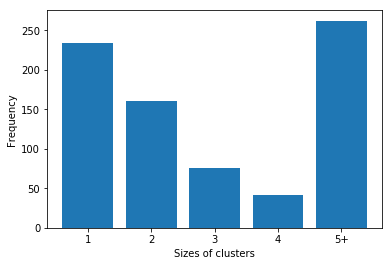


./LargerDataset/2016_12_17__0723(ext).czi_3100_job2893.object_results.p
Number of clusters: 4812.0
[1252.  784.  481.  307. 1988.]


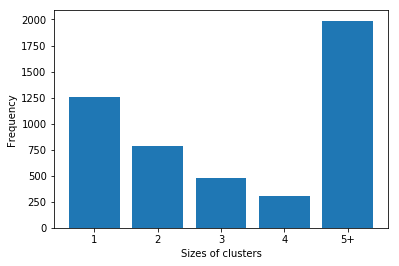


./LargerDataset/2016_12_17__0724(ext).czi_3101_job2894.object_results.p
Number of clusters: 3596.0
[ 400.  219.  162.  118. 2697.]


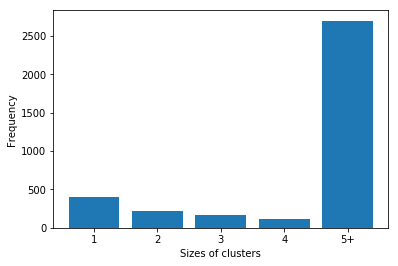


./LargerDataset/2016_12_17__0725(ext).czi_3102_job2895.object_results.p
Number of clusters: 4511.0
[ 784.  512.  273.  194. 2748.]


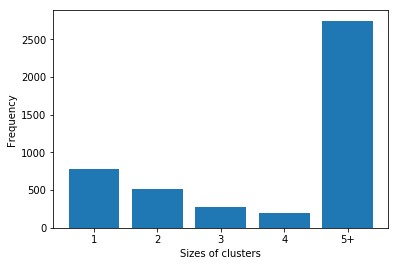


./LargerDataset/2016_12_17__0727(ext).czi_3104_job2896.object_results.p
Number of clusters: 677.0
[209. 137.  84.  44. 203.]


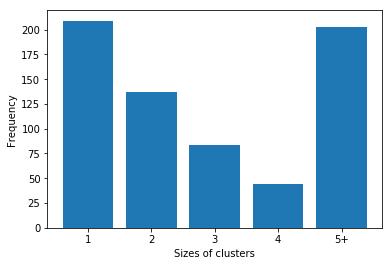


./LargerDataset/2016_12_17__0728(ext).czi_3105_job2898.object_results.p
Number of clusters: 2543.0
[ 579.  395.  235.  197. 1137.]


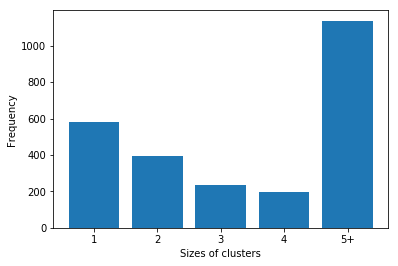


./LargerDataset/2016_12_17__0729(ext).czi_3106_job2897.object_results.p
Number of clusters: 831.0
[306. 132.  48.  49. 296.]


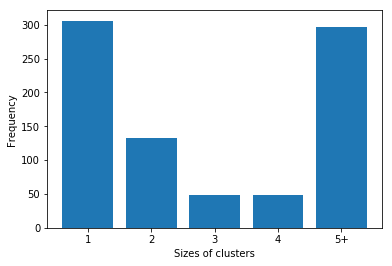


./LargerDataset/2016_12_17__0730(ext).czi_3107_job2899.object_results.p
Number of clusters: 1605.0
[425. 267. 127. 110. 676.]


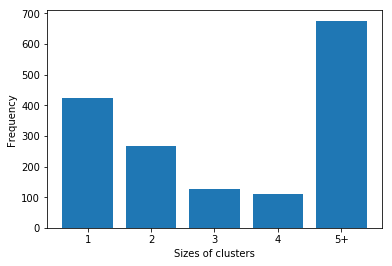


./LargerDataset/2016_12_17__0731(ext).czi_3108_job2900.object_results.p
Number of clusters: 1989.0
[428. 306. 212. 136. 907.]


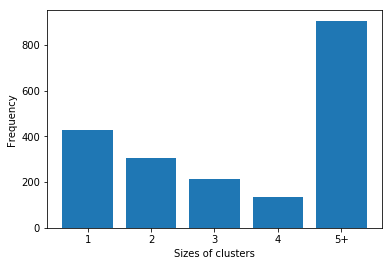


./LargerDataset/2016_12_17__0732(ext).czi_3109_job2901.object_results.p
Number of clusters: 932.0
[396. 145.  80.  39. 272.]


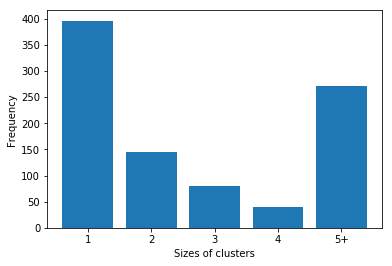


./LargerDataset/2016_12_17__0733(ext).czi_3110_job2903.object_results.p
Number of clusters: 1043.0
[352. 159.  87.  38. 407.]


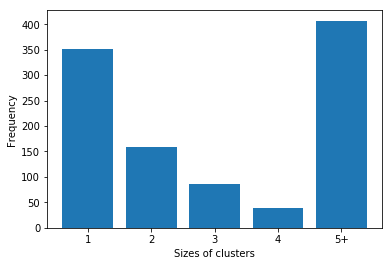


./LargerDataset/2016_12_17__0734(Ext).czi_3111_job2907.object_results.p
Number of clusters: 2795.0
[ 708.  396.  256.  166. 1269.]


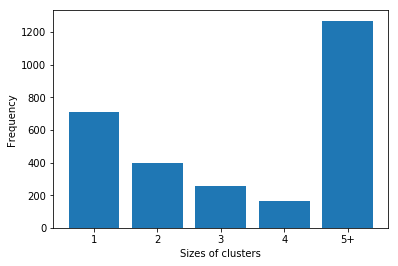


./LargerDataset/2016_12_17__0735(Ext).czi_3112_job2905.object_results.p
Number of clusters: 3747.0
[ 928.  619.  372.  271. 1557.]


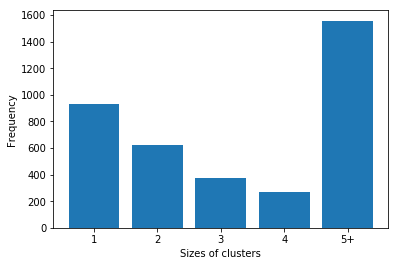


./LargerDataset/2016_12_17__0736(ext).czi_3113_job2906.object_results.p
Number of clusters: 3696.0
[1036.  651.  367.  275. 1367.]


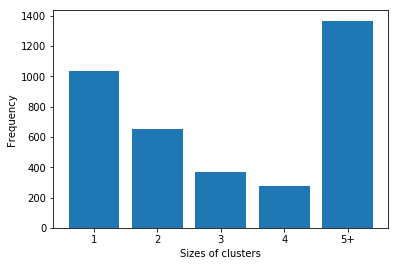


./LargerDataset/2016_12_17__0737(ext).czi_3114_job2909.object_results.p
Number of clusters: 1586.0
[466. 286. 134.  80. 620.]


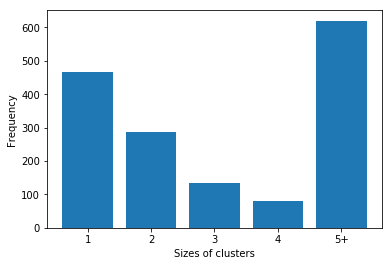


./LargerDataset/2016_12_17__0738(ext).czi_3115_job2910.object_results.p
Number of clusters: 1110.0
[380. 163.  88.  53. 426.]


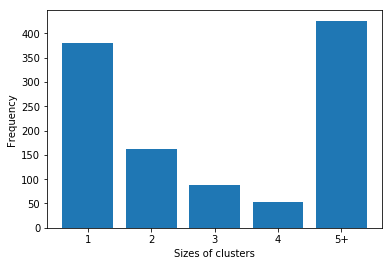


./LargerDataset/2016_12_17__0739(ext).czi_3116_job2911.object_results.p
Number of clusters: 1891.0
[470. 331. 183. 120. 787.]


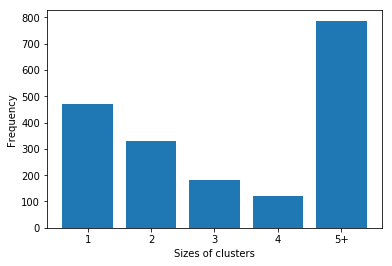


./LargerDataset/2016_12_17__0740(Ext).czi_3117_job2912.object_results.p
Number of clusters: 4331.0
[ 947.  715.  476.  290. 1903.]


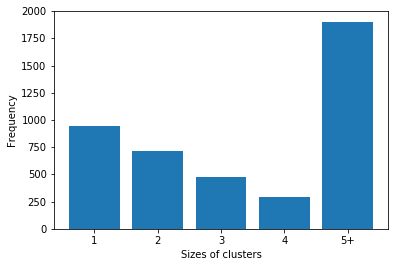


./LargerDataset/2016_12_17__0741(ext).czi_3118_job2913.object_results.p
Number of clusters: 955.0
[232. 172. 103.  65. 383.]


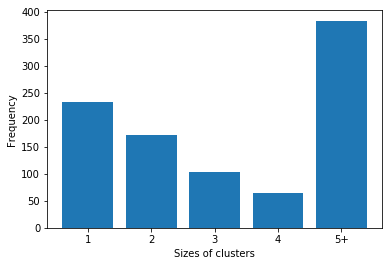


./LargerDataset/2016_12_17__0742(ext).czi_3119_job2914.object_results.p
Number of clusters: 2181.0
[462. 373. 273. 178. 895.]


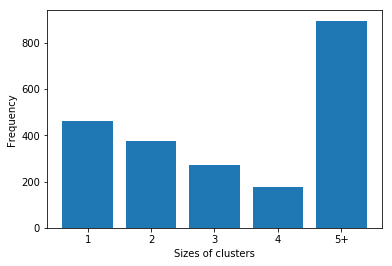


./LargerDataset/2016_12_17__0744(Ext).czi_3121_job2915.object_results.p
Number of clusters: 3399.0
[ 629.  513.  309.  229. 1719.]


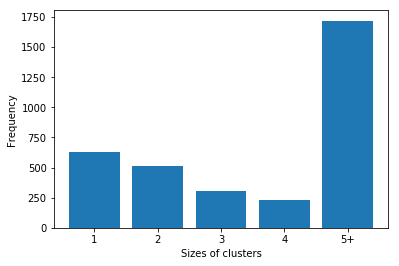


./LargerDataset/2016_12_17__0745(ext).czi_3122_job2916.object_results.p
Number of clusters: 1434.0
[354. 241. 140. 111. 588.]


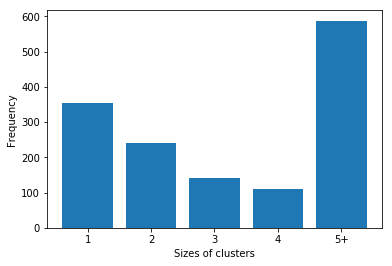


./LargerDataset/2016_12_17__0746(ext).czi_3123_job2917.object_results.p
Number of clusters: 3261.0
[ 782.  489.  254.  184. 1552.]


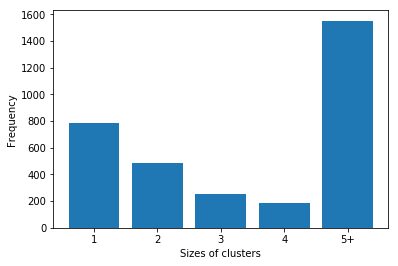


./LargerDataset/2016_12_17__0747(ext).czi_3124_job2918.object_results.p
Number of clusters: 1712.0
[562. 320. 195. 100. 535.]


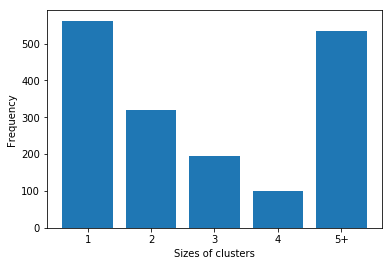


./LargerDataset/2016_12_17__0748(ext).czi_3125_job2919.object_results.p
Number of clusters: 894.0
[245. 141.  81.  41. 386.]


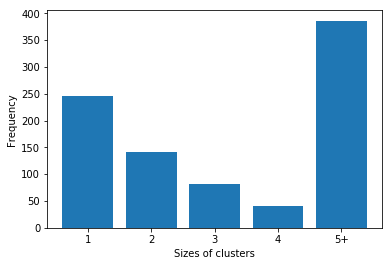


./LargerDataset/2016_12_17__0749(ext).czi_3126_job2920.object_results.p
Number of clusters: 1478.0
[496. 247. 143.  91. 501.]


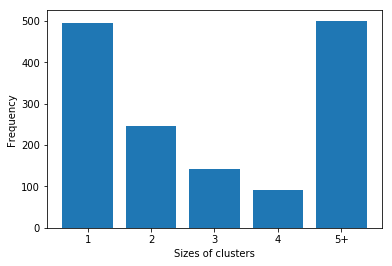


./LargerDataset/2016_12_17__0750(ext).czi_3127_job2921.object_results.p
Number of clusters: 936.0
[371. 156.  87.  54. 268.]


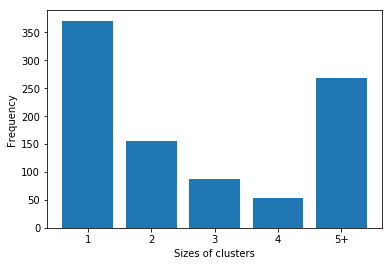


./LargerDataset/2016_12_17__0751(ext).czi_3128_job2922.object_results.p
Number of clusters: 1190.0
[382. 229.  96.  81. 402.]


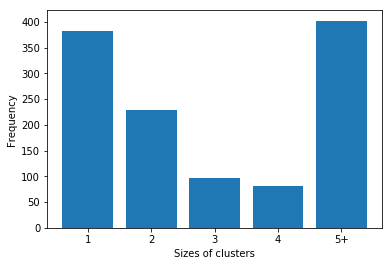


./LargerDataset/2016_12_17__0752(ext).czi_3129_job2923.object_results.p
Number of clusters: 362.0
[126.  30.  13.  15. 178.]


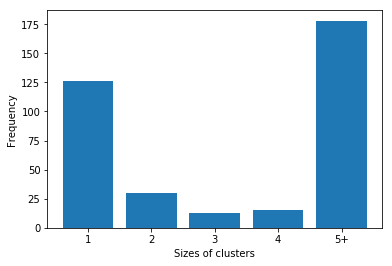


./LargerDataset/2016_12_17__0753(ext).czi_3130_job2924.object_results.p
Number of clusters: 1421.0
[378. 180. 106.  62. 695.]


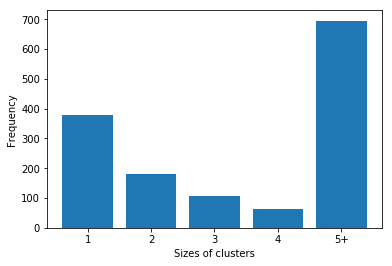


./LargerDataset/2016_12_17__0754(ext).czi_3131_job2925.object_results.p
Number of clusters: 1240.0
[492. 225.  93.  67. 363.]


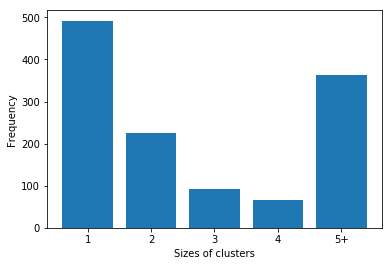


./LargerDataset/2016_12_17__0755(ext).czi_3132_job2926.object_results.p
Number of clusters: 1210.0
[343. 212. 144. 101. 410.]


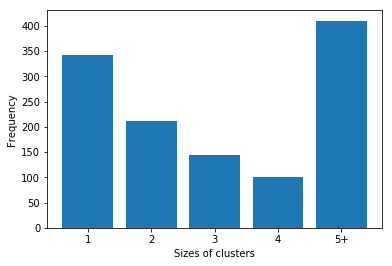


./LargerDataset/2016_12_17__0757(ext).czi_3133_job2927.object_results.p
Number of clusters: 295.0
[107.  43.  16.  16. 113.]


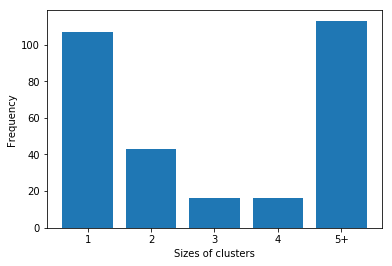


./LargerDataset/2016_12_17__0758(ext).czi_3134_job2928.object_results.p
Number of clusters: 1894.0
[423. 270. 195.  93. 913.]


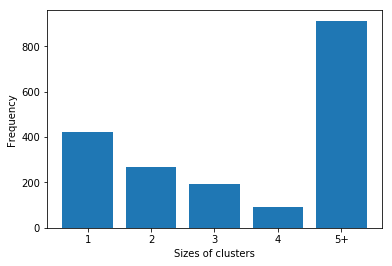


./LargerDataset/2016_12_17__0759(ext).czi_3135_job2935.object_results.p
Number of clusters: 1441.0
[216. 159. 110.  88. 868.]


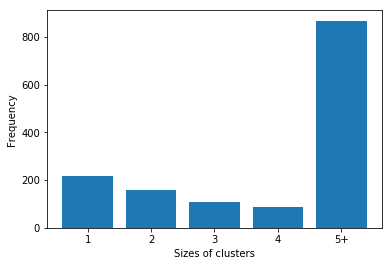


./LargerDataset/2016_12_17__0760(Ext).czi_3136_job2934.object_results.p
Number of clusters: 1576.0
[365. 226. 145.  92. 748.]


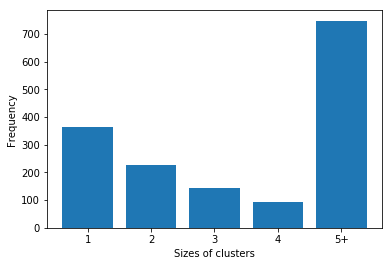


./LargerDataset/2016_12_17__0761(ext).czi_3137_job2933.object_results.p
Number of clusters: 959.0
[306. 149.  87.  70. 347.]


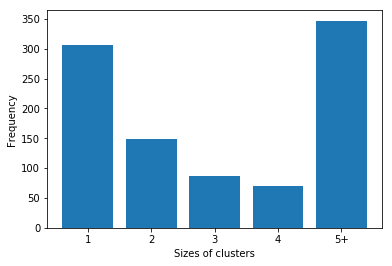


./LargerDataset/2016_12_17__0762(ext).czi_3138_job2932.object_results.p
Number of clusters: 821.0
[204. 110.  91.  54. 362.]


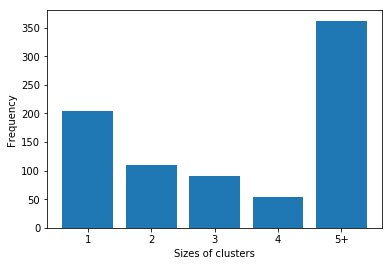


./LargerDataset/2016_12_17__0763(ext).czi_3139_job2931.object_results.p
Number of clusters: 1191.0
[326. 230. 127.  68. 440.]


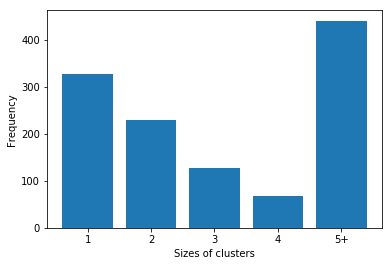


./LargerDataset/2016_12_17__0764(Ext).czi_3140_job2930.object_results.p
Number of clusters: 987.0
[290. 169.  84.  44. 400.]


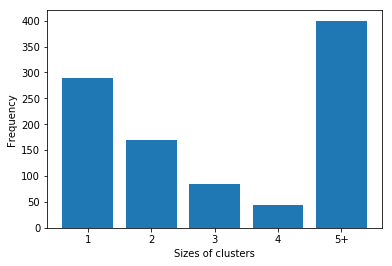


./LargerDataset/2016_12_17__0765(Ext).czi_3141_job2929.object_results.p
Number of clusters: 2373.0
[645. 407. 237. 179. 905.]


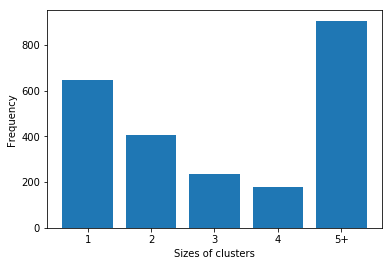


./LargerDataset/2016_12_17__0767(ext).czi_3143_job2936.object_results.p
Number of clusters: 782.0
[287. 124.  56.  34. 281.]


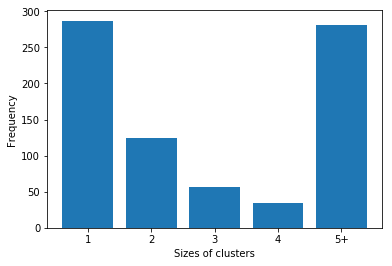


./LargerDataset/2016_12_17__0768(Ext).czi_3144_job2937.object_results.p
Number of clusters: 1613.0
[412. 219. 137.  92. 753.]


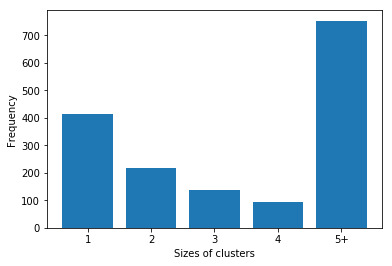


./LargerDataset/2016_12_17__0769(ext).czi_3145_job2938.object_results.p
Number of clusters: 605.0
[240.  80.  47.  26. 212.]


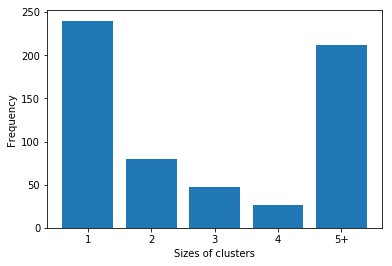


./LargerDataset/2016_12_17__0770(ext).czi_3146_job2939.object_results.p
Number of clusters: 1095.0
[320. 160.  93.  63. 459.]


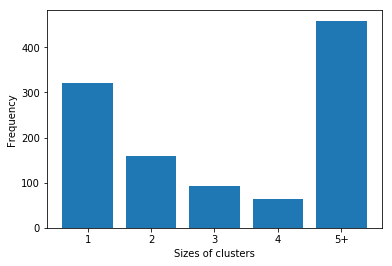


./LargerDataset/2016_12_17__0772.czi_3045_job2836.object_results.p
Number of clusters: 1282.0
[399. 220. 123.  69. 471.]


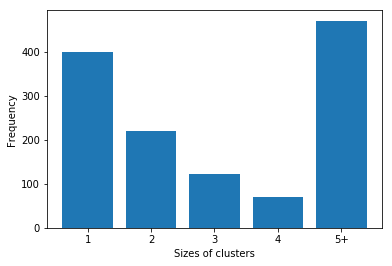


./LargerDataset/2016_12_17__0774.czi_3047_job2837.object_results.p
Number of clusters: 3410.0
[ 889.  553.  265.  196. 1507.]


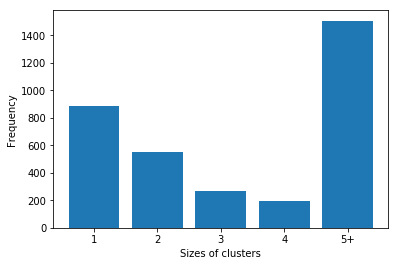


./LargerDataset/2016_12_17__0775.czi_3049_job2838.object_results.p
Number of clusters: 902.0
[307. 179.  91.  46. 279.]


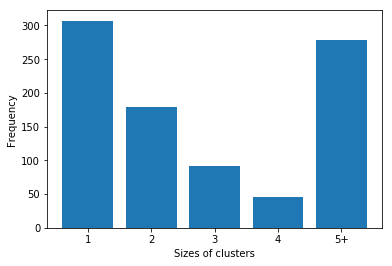


./LargerDataset/2016_12_17__0776.czi_3051_job2839.object_results.p
Number of clusters: 794.0
[281. 137.  65.  44. 267.]


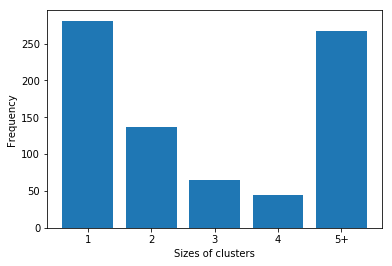


./LargerDataset/2016_12_17__0777.czi_3029_job2858.object_results.p
Number of clusters: 2578.0
[742. 519. 277. 187. 853.]


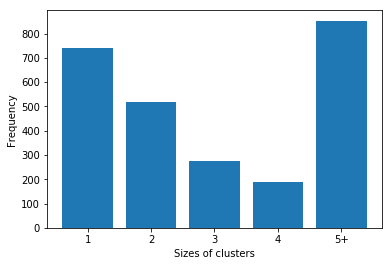


./LargerDataset/2016_12_17__0778.czi_3031_job2845.object_results.p
Number of clusters: 794.0
[249. 136.  88.  49. 272.]


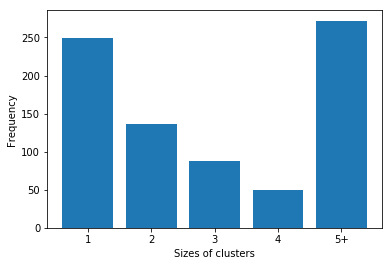


./LargerDataset/2016_12_17__0779(ext).czi_3147_job2940.object_results.p
Number of clusters: 1489.0
[584. 263. 138.  87. 417.]


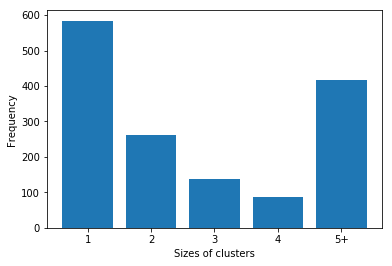


./LargerDataset/2016_12_17__0780(ext).czi_3148_job2943.object_results.p
Number of clusters: 1403.0
[534. 273. 138.  83. 375.]


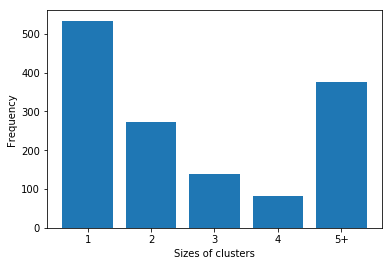


./LargerDataset/2016_12_17__0781(ext).czi_3149_job2942.object_results.p
Number of clusters: 4897.0
[1000.  654.  419.  296. 2528.]


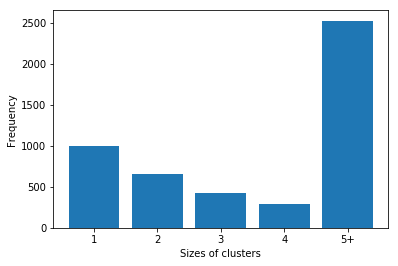


./LargerDataset/2016_12_17__0782(ext).czi_3150_job2941.object_results.p
Number of clusters: 1193.0
[356. 178. 117.  65. 477.]


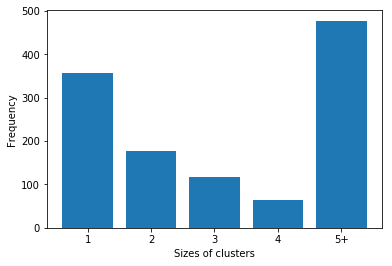


./LargerDataset/2016_12_17__0783(ext).czi_3151_job2946.object_results.p
Number of clusters: 3606.0
[1163.  559.  389.  239. 1256.]


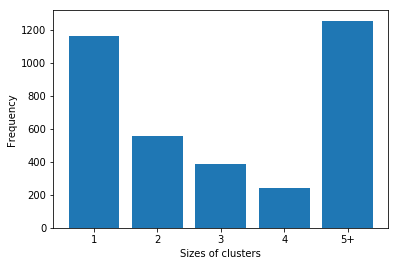


./LargerDataset/2016_12_17__0784(ext).czi_3152_job2945.object_results.p
Number of clusters: 2917.0
[ 611.  380.  266.  191. 1469.]


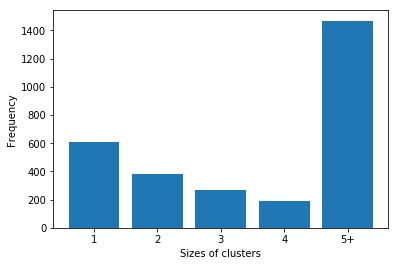


./LargerDataset/2016_12_17__0785(ext).czi_3153_job2944.object_results.p
Number of clusters: 3601.0
[ 788.  446.  263.  203. 1901.]


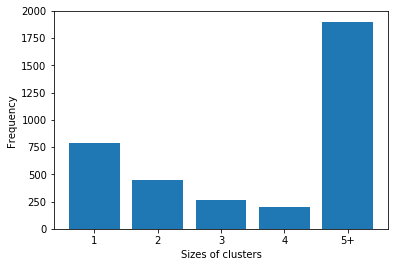


./LargerDataset/2016_12_28__0786(ext).czi_3154_job2950.object_results.p
Number of clusters: 2077.0
[659. 459. 232. 157. 570.]


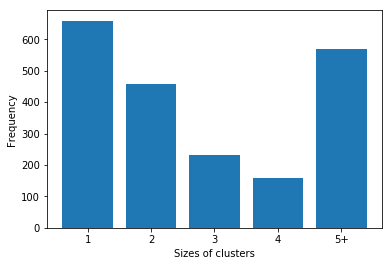


./LargerDataset/2016_12_28__0787(ext).czi_3155_job2951.object_results.p
Number of clusters: 1395.0
[317. 216. 122.  76. 664.]


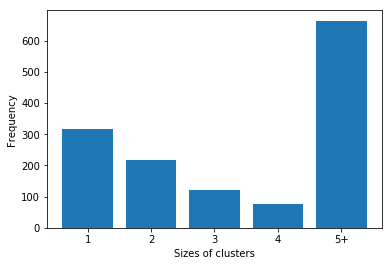


./LargerDataset/2016_12_28__0788(ext).czi_3156_job2952.object_results.p
Number of clusters: 835.0
[257. 141.  93.  49. 295.]


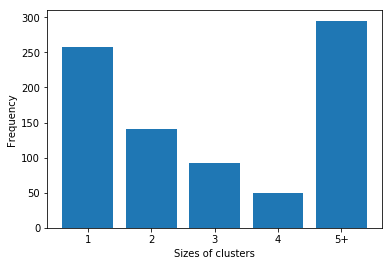


./LargerDataset/2016_12_28__0790(ext).czi_3158_job2953.object_results.p
Number of clusters: 1055.0
[387. 159. 107.  69. 333.]


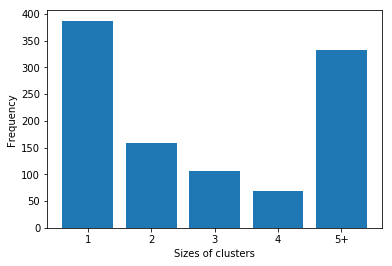


./LargerDataset/2016_12_28__0791(ext).czi_3159_job2954.object_results.p
Number of clusters: 604.0
[209.  95.  64.  27. 209.]


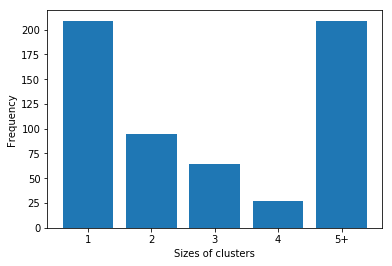


./LargerDataset/2016_12_28__0792(ext).czi_3160_job2955.object_results.p
Number of clusters: 842.0
[277. 145.  79.  64. 277.]


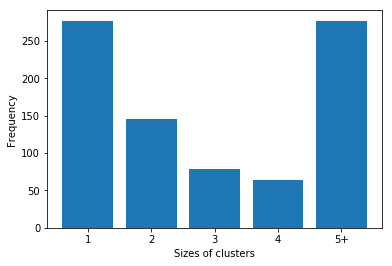


./LargerDataset/2016_12_28__0793(ext).czi_3161_job2956.object_results.p
Number of clusters: 5508.0
[1453. 1047.  608.  362. 2038.]


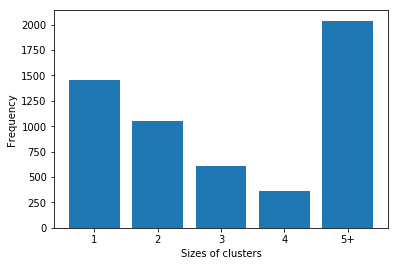


./LargerDataset/2016_12_29__0795.czi_3052_job2840.object_results.p
Number of clusters: 1203.0
[410. 211. 127.  84. 371.]


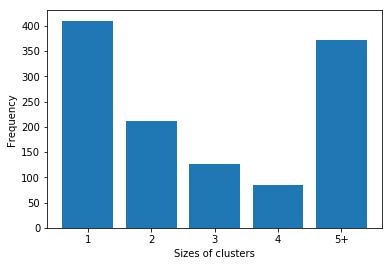


./LargerDataset/2016_12_29__0796.czi_3054_job2841.object_results.p
Number of clusters: 1794.0
[562. 268. 158. 107. 699.]


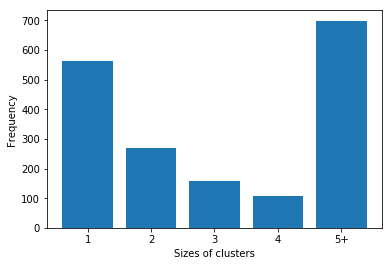


./LargerDataset/2016_12_29__0797.czi_3056_job2843.object_results.p
Number of clusters: 1029.0
[353. 165.  91.  47. 373.]


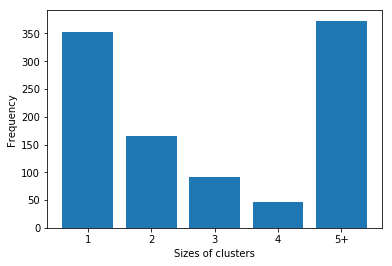


./LargerDataset/2016_12_29__0798(ext).czi_3163_job2949.object_results.p
Number of clusters: 1716.0
[445. 314. 199. 124. 634.]


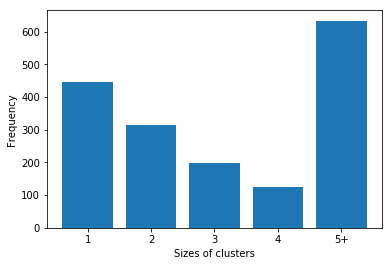


./LargerDataset/2016_12_29__0799.czi_3058_job2831.object_results.p
Number of clusters: 945.0
[322. 143.  75.  38. 367.]


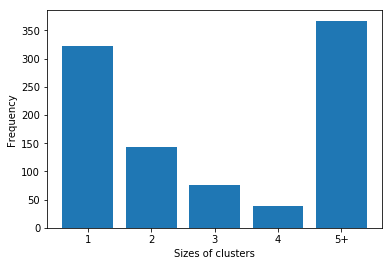


./LargerDataset/2016_12_29__0800.czi_3060_job2835.object_results.p
Number of clusters: 703.0
[177. 102.  56.  32. 336.]


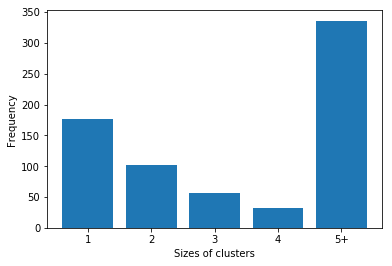


./LargerDataset/2016_12_29__0801(ext).czi_3164_job2948.object_results.p
Number of clusters: 1045.0
[338. 172.  98.  72. 365.]


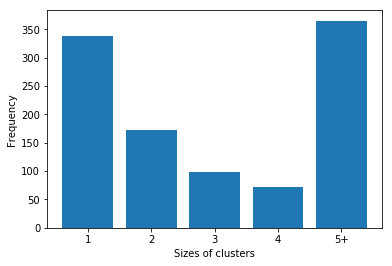


./LargerDataset/2016_12_29__0803(ext).czi_3165_job2947.object_results.p
Number of clusters: 1394.0
[357. 182.  87.  39. 729.]


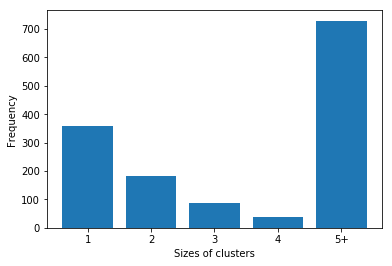


./LargerDataset/2016_12_29__0804.czi_3062_job2834.object_results.p
Number of clusters: 1291.0
[406. 191. 108.  50. 536.]


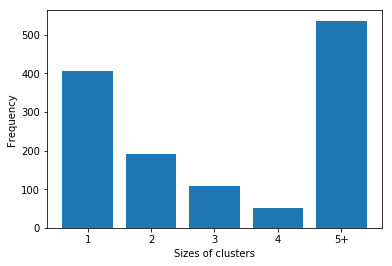


./LargerDataset/2016_12_29__0805.czi_3033_job2856.object_results.p
Number of clusters: 2629.0
[ 678.  376.  222.  165. 1188.]


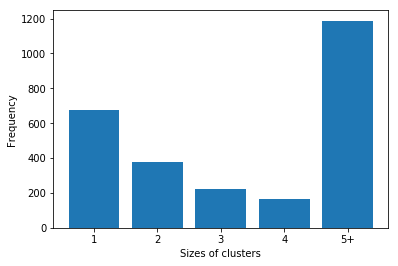


./LargerDataset/2017_08_04__3300.czi_3034_job3032.object_results.p
Number of clusters: 1406.0
[555. 263. 140.  81. 367.]


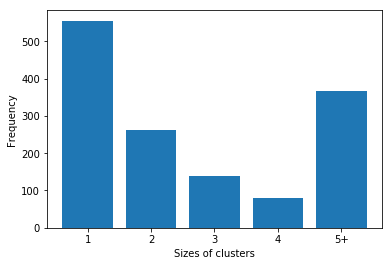


./LargerDataset/2017_08_04__3301.czi_3035_job3033.object_results.p
Number of clusters: 3740.0
[1290.  637.  353.  217. 1243.]


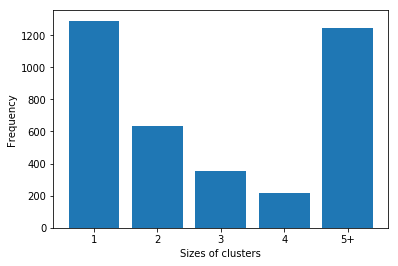


./LargerDataset/2017_08_04__3302.czi_3036_job3034.object_results.p
Number of clusters: 837.0
[216. 117.  85.  35. 384.]


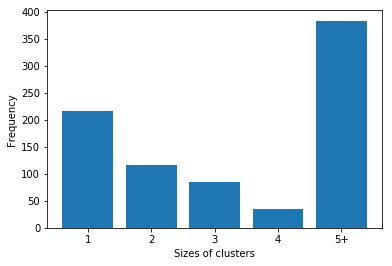


./LargerDataset/2017_08_04__3303.czi_3037_job3035.object_results.p
Number of clusters: 1748.0
[605. 286. 158.  87. 612.]


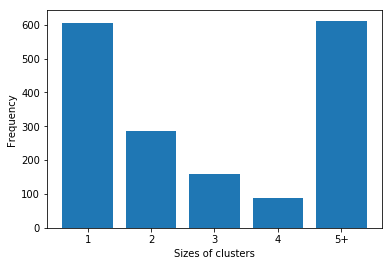


./LargerDataset/2017_08_04__3304.czi_3038_job3036.object_results.p
Number of clusters: 2637.0
[962. 540. 290. 154. 691.]


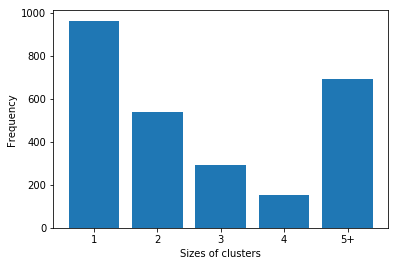


./LargerDataset/2017_08_04__3305.czi_3039_job3037.object_results.p
Number of clusters: 9287.0
[3567. 1718.  898.  580. 2524.]


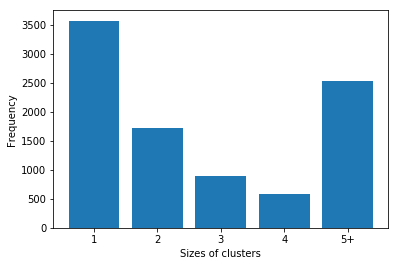


./LargerDataset/2017_08_04__3307.czi_3040_job3038.object_results.p
Number of clusters: 1551.0
[551. 221. 148.  82. 549.]


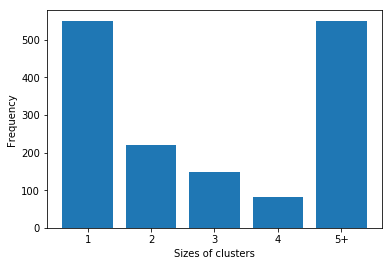


./LargerDataset/2017_08_04__3308.czi_3041_job3039.object_results.p
Number of clusters: 3219.0
[1321.  593.  299.  191.  815.]


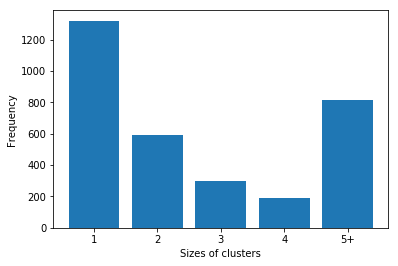


./LargerDataset/SN16.czi_3042_job3040.object_results.p
Number of clusters: 1519.0
[533. 243. 143.  85. 515.]


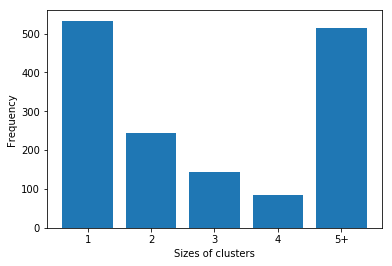


./LargerDataset/SN20.czi_3043_job3041.object_results.p
Number of clusters: 1856.0
[797. 255. 115.  76. 613.]


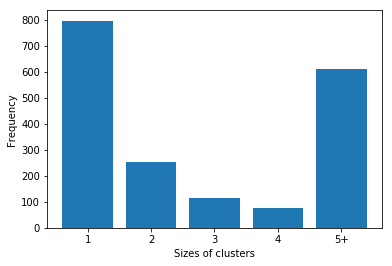

In [6]:
m = 115
upper = 5
    
X, y, positives = Loader.load_new_dataset_singular(m=115, upper=upper, display_plot=True, pretty_print=True)

features = [str(i+1) for i in range(X.shape[1])]
features[-1] = features[-1] + '+'

X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                 np.take(y, positives, axis=0), np.delete(y, positives, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

In [ ]:
# Preprocess X_train, y_train (potentially augment, e.g. SMOTE)
# Leave this one for now.
print("X_minority:", X_minority.shape)
print("y_minority:", y_minority.shape)
print("--------------")
print("X_majority:", X_majority.shape)
print("y_majority:", y_majority.shape)
print("--------------")
print("X:", X.shape)
print("y:", y.shape)

In [21]:
sampler = SMOTE(random_state=0)
X_smote, y_smote = sampler.fit_sample(X, y)

print("X_smote:", X_smote.shape)
print("y_smote:", y_smote.shape)
print("--------------")
stacked = np.concatenate((X_smote, y_smote.reshape(y_smote.shape[0], 1)), 1)

smote_positives = np.where(stacked[:,-1] == 1)
smote_positives = smote_positives[0]

X_minority_smote = np.take(X_smote, smote_positives, axis=0)
X_majority_smote = np.delete(X_smote, smote_positives, axis=0)
y_minority_smote = np.take(y_smote, smote_positives, axis=0)
y_majority_smote = np.delete(y_smote, smote_positives, axis=0)
            
print("X_minority_smote:", X_minority_smote.shape)
print("y_minority_smote:", y_minority_smote.shape)
print("--------------")
print("X_majority_smote:", X_majority_smote.shape)
print("y_majority_smote:", y_majority_smote.shape)

X_smote: (200, 10)
y_smote: (200,)
--------------
X_minority_smote: (100, 10)
y_minority_smote: (100,)
--------------
X_majority_smote: (100, 10)
y_majority_smote: (100,)


[0.4375     0.625      0.625      0.375      0.5        0.64285714
 0.5        0.64285714 0.57142857 0.42857143]


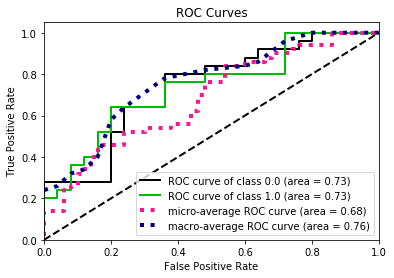

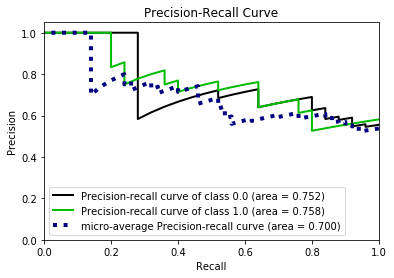

In [33]:
# Partition
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, stratify=y_smote)
# Pick a baseline classifier - Naive Bayes
nb = GaussianNB()

# Very large class imbalance, so use stratified K-fold cross-validation.
cross_val = StratifiedKFold(n_splits=10, random_state=0)

# Use RFE for feature selection
est = svm.SVR(kernel="linear")
selector = feature_selection.RFE(est)

# Create pipeline
clf = Pipeline(steps=[("feature selection", selector), ("classifier", nb)])

# Score using F1-score due to class imbalance
scores = cross_val_score(clf, X_train, y_train, cv=cross_val, scoring=make_scorer(f1_score, average='micro'))

# Fit and make predictions. Use these to plot ROC curves.
print(scores)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(y_test, y_pred)
plt.show()

(200, 10)
10
1-20


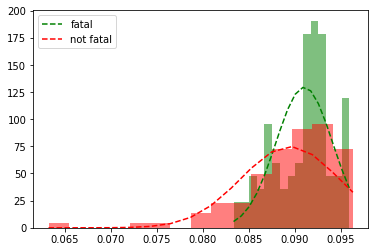

1-40


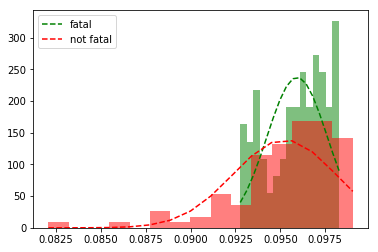

1-60


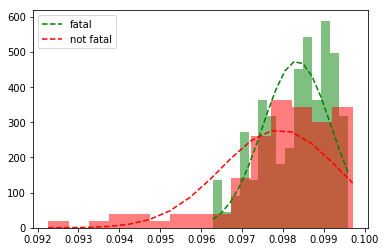

1-80


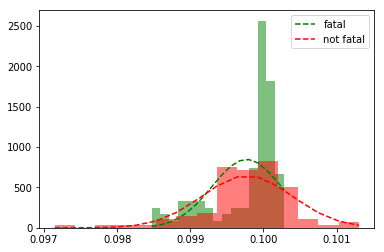

1-100


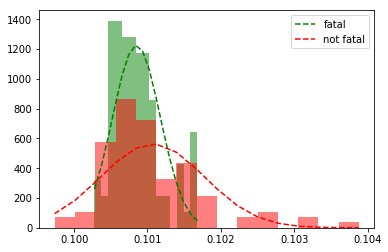

1-120


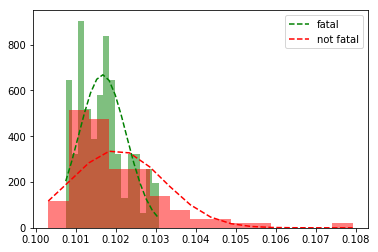

1-140


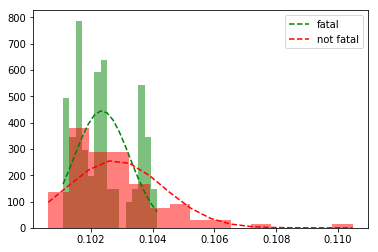

1-160


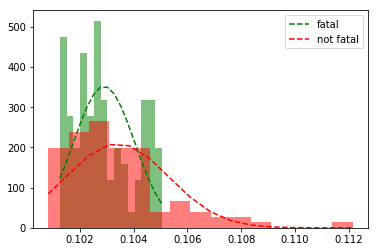

1-180


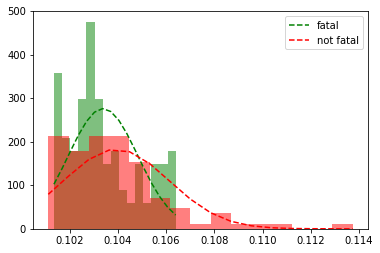

1-200


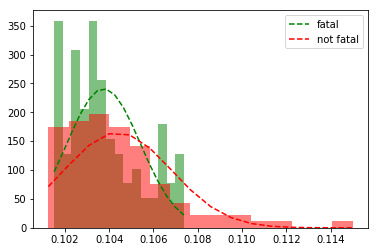

In [34]:
from scipy.stats import norm

print(X_smote.shape)
print(len(features))

for i in range(X_smote.shape[1]):
    print(features[i])
    # For the positive class (green)
    mu_fl = np.mean(X_minority_smote[:,i])
    sigma_fl = np.std(X_minority_smote[:,i])
    num_bins = 15
    n_fl, bins_fl, patches_fl = plt.hist(X_minority_smote[:,i], num_bins, density=True, facecolor='green', alpha=0.5)
    y_fl = norm.pdf(bins_fl, mu_fl, sigma_fl)
    plt.plot(bins_fl, y_fl, 'g--',label='fatal')

    # For the negative class (red)
    mu_nofl = np.mean(X_majority_smote[:,i])
    sigma_nofl = np.std(X_majority_smote[:,i])
    n_nofl, bins_nofl, patches_nofl = plt.hist(X_majority_smote[:,i], num_bins, density=True, facecolor='red', alpha=0.5)
    y_nofl = norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
    plt.plot(bins_nofl, y_nofl, 'r--', label='not fatal')
    plt.legend()
    plt.show()

Feature ranking:
1. feature 1-80, 3, (0.146918)
2. feature 1-140, 6, (0.111920)
3. feature 1-60, 2, (0.099780)
4. feature 1-120, 5, (0.097502)
5. feature 1-40, 1, (0.097204)
6. feature 1-100, 4, (0.096194)
7. feature 1-160, 7, (0.094294)
8. feature 1-180, 8, (0.087253)
9. feature 1-200, 9, (0.084756)
10. feature 1-20, 0, (0.084177)


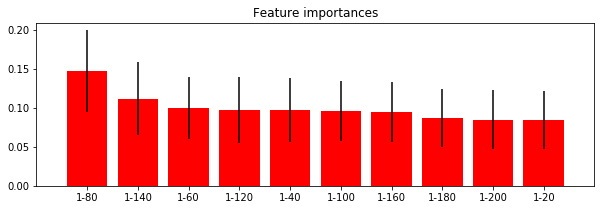

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0)

forest.fit(X_smote, y_smote)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

ordered_features = []

for f in range(X.shape[1]):
    print("%d. feature %s, %d, (%f)" % (f + 1, features[indices[f]], indices[f], importances[indices[f]]))
    ordered_features.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(10, 3))
plt.title("Feature importances")
plt.bar(range(X_smote.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_smote.shape[1]), ordered_features)
plt.xlim([-1, X_smote.shape[1]])
plt.show()

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif  # import the feature selection method
N_features = 2                                                # select the number of features 
Nfl = X_minority_smote.shape[0]; Nnofl = X_majority_smote.shape[0]
yfl = np.ones(Nfl); ynofl = np.zeros(Nnofl)
selector = SelectKBest(f_classif, k=N_features)               # k is the number of features
selector.fit(np.concatenate((X_minority_smote,X_majority_smote),axis=0), np.concatenate((yfl, ynofl), axis=0))
scores=selector.scores_
print(scores)

[6.40340608 4.51261545 6.54799096 0.00914113 7.90827051 7.37634489
 5.6946551  4.93225821 4.40609651 4.6928834 ]


Features (sizes of clusters): ['1-20', '1-40', '1-60', '1-80', '1-100', '1-120', '1-140', '1-160', '1-180', '1-200']


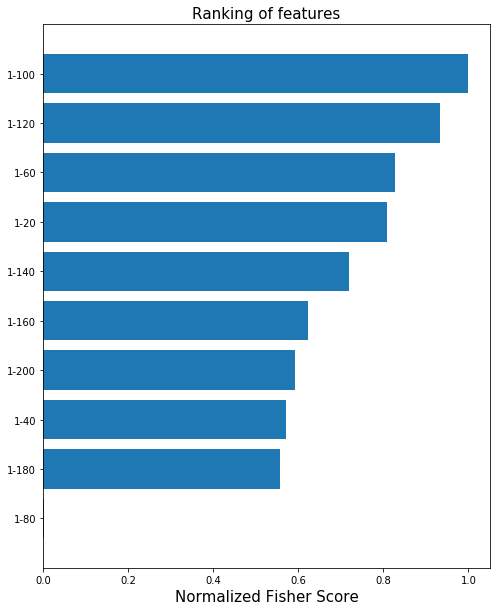

In [37]:
plt.clf()
order = np.argsort(scores)

print("Features (sizes of clusters):", features)

orderedfeatures = [features[i] for i in order]
y_pos2 = np.arange(len(features))
plt.barh(y_pos2, sorted(scores/np.max(scores)), align='center')
plt.ylim((-1, len(features)))
plt.yticks(y_pos2, orderedfeatures)
plt.xlabel('Normalized Fisher Score', fontsize=15)
plt.title('Ranking of features', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(8,10)
plt.show()

In [ ]:
# Evaluate using the acquired class predictions/probabilities or regression - e.g. plot training and validation error rates to detect overfitting or underfitting.

In [ ]:
from sklearn.datasets import make_classification

# Randomly generate a dataset with similar characteristics (size, class balance, num_features)
# X, y = make_classification(n_samples=1150, n_features=21, random_state=0, n_classes=2)
# X, y = make_classification(n_samples=200, n_features=21, random_state=0, n_classes=2, \
#                            weights=[0.50, 0.50], n_informative=5, n_clusters_per_class=3)

positives = np.where(y == 1)

# Partition
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                 np.take(y, positives, axis=0), np.delete(y, positives, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

# Cross-validation again
cross_val = StratifiedKFold(n_splits=10)

# Use Naive Bayes again for consistency
clf = GaussianNB()

# Likewise for the evaluation metric
scores = cross_val_score(clf, X_train, y_train, cv=cross_val, scoring=make_scorer(f1_score, average='micro'))

print(scores)

# Fit, predict, plot results
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

In [ ]:
from sklearn.model_selection import KFold

kf = StratifiedKFold(n_splits=10).split(X_train, y_train)

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))

for i, (train, test) in enumerate(kf):
    model = GaussianNB().fit(X_train[train], y_train[train])
    y_score = model.predict_proba(X_train[test])
    fpr, tpr, _ = roc_curve(y_train[test], y_score[:, 1])

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.show()

In [38]:
def try_classifier(classifier):
    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    plt.figure(figsize=(5, 5))

    idx = np.arange(0, len(y_train))

    for j in np.random.randint(0, high=10000, size=10):
        np.random.shuffle(idx)
        kf = StratifiedKFold(n_splits=10, random_state=j).split(X_train, y_train)

        for i, (train, test) in enumerate(kf):
            model = classifier.fit(X_train[idx][train], y_train[idx][train])
            y_score = model.predict_proba(X_train[idx][test])
            fpr, tpr, _ = roc_curve(y_train[idx][test], y_score[:, 1])

            plt.plot(fpr, tpr, 'b', alpha=0.05)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

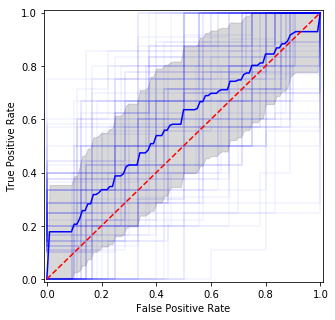

In [39]:
try_classifier(GaussianNB())

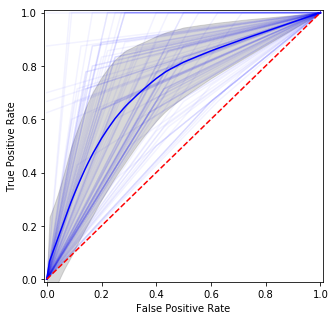

In [40]:
try_classifier(DecisionTreeClassifier())

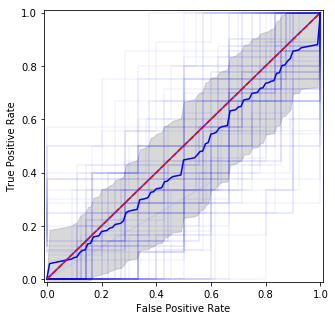

In [42]:
try_classifier(svm.SVC(probability=True, kernel="rbf", C=100))

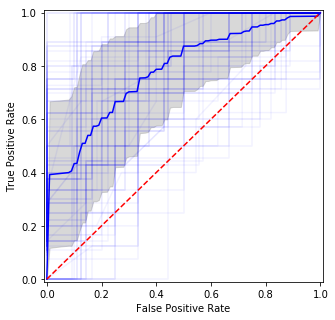

In [45]:
try_classifier(RandomForestClassifier(max_depth=5))